Step 1. Follow along with the tutorial to gain an understanding of the process<br>
Step 2. In a new .ipynb notebook, reproduce the results utilizing the "QMNIST" dataset

In [4]:
# import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Load "QMNIST" dataset and preprocess

# transforms.compose is used to chain together mutliple images, using a transformation pipeline  with two transformations
# ToTensor is used to convert image to Pytorch tensor, scale pixels to (0.0, 1.0)
# Normalizes the tensor by subracting the mean and divinding by sd. Mean and sd are 0.5, 0.5.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
train_dataset = torchvision.datasets.QMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.QMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9704059/9704059 [00:00<00:00, 305101597.25it/s]

Extracting ./data/QMNIST/raw/qmnist-train-images-idx3-ubyte.gz to ./data/QMNIST/raw


100%|██████████| 463024/463024 [00:00<00:00, 66509021.07it/s]

Extracting ./data/QMNIST/raw/qmnist-train-labels-idx2-int.gz to ./data/QMNIST/raw


100%|██████████| 9742279/9742279 [00:00<00:00, 236224302.11it/s]

Extracting ./data/QMNIST/raw/qmnist-test-images-idx3-ubyte.gz to ./data/QMNIST/raw


100%|██████████| 526800/526800 [00:00<00:00, 44937143.53it/s]

Extracting ./data/QMNIST/raw/qmnist-test-labels-idx2-int.gz to ./data/QMNIST/raw


In [6]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
# show sample information
first_sample = train_dataset[0]
image, label = first_sample

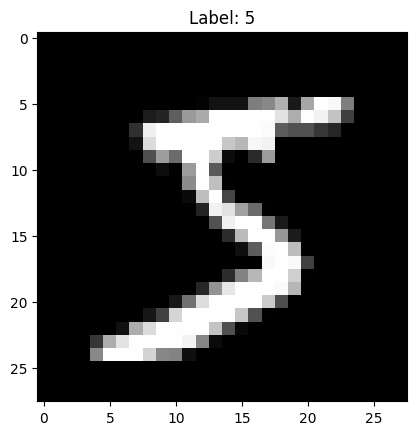

In [5]:
# Convert the PyTorch tensor to a NumPy array
image_np = np.transpose(image.numpy(), (1, 2, 0))  # Assuming the image is in shape (C, H, W)

# Denormalize the image (reverse the normalization process)
image_denormalized = 0.5 * image_np + 0.5

# Display the image
plt.imshow(image_denormalized, cmap='gray')
plt.title(f'Label: {label}')
plt.show()


In [6]:
unique_labels = set()

for _, label in train_dataset:
    unique_labels.add(label)

unique_labels_list = list(unique_labels)

print("unique labels", unique_labels_list)

unique labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


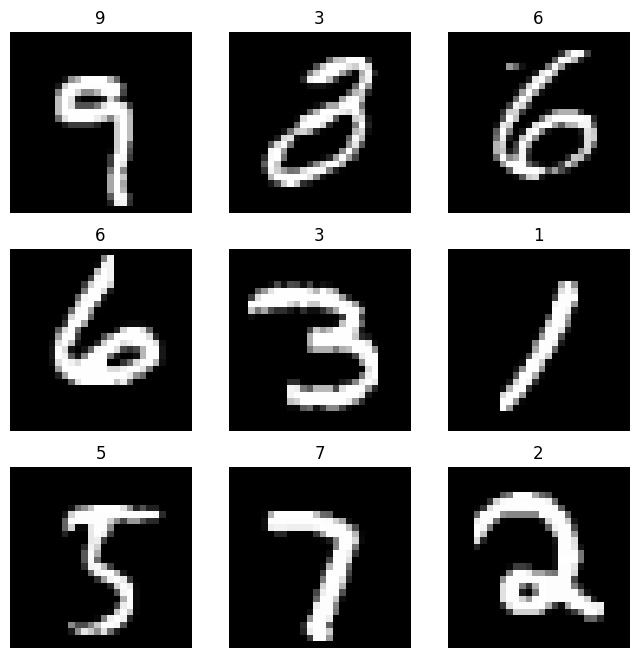

In [7]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

figure = plt.figure(figsize=(8, 8))
# Define grid to show 9 images
cols, rows = 3, 3
# Iterate
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

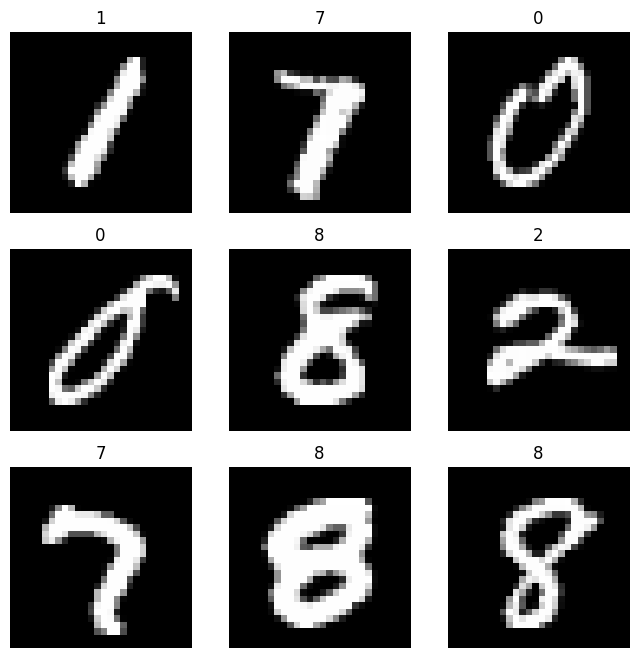

In [8]:
#Test DataSet
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
# Define nn architecture
# Define a class MLP which inherits from nn module
class MLP(nn.Module):
  # Dfine a constructor for MLP class, initialize the layers of nn within
    def __init__(self):
        # Constructor of parent class using 'super'
        super(MLP, self).__init__()
        # Creates the first fully connected layer, input size is 28*28 which
        # is usually an  images, output size is 128 neurons
        self.fc1 = nn.Linear(28*28, 128)
        # Second fully connected layer, with input size of 128 from previous layer
        # output size of 64
        self.fc2 = nn.Linear(128, 64)
        # Third fully connected layer, with input size of 64 neurons
        # out is 10, which is inline with the number of classes
        self.fc3 = nn.Linear(64, 10)

    # Deines a forward pass, how data is processed thru layers
    def forward(self, x):
        # Reshapes x into 2D sensor. Using -1 as a placeholder, allowing
        # Pytorch is automtically infer the size laong that dimension based
        x = x.view(-1, 28*28)
        # The reshapred input passes thru first fully connected layer, applies
        # activation function relu - rectified linear unit to output of fc1
        # ReLU introduces non-linearity to model by setting negative values to 0
        x = torch.relu(self.fc1(x))
        # Same as prior layer
        x = torch.relu(self.fc2(x))
        # No activation function is applied, raw outputfor each class is obtained
        x = self.fc3(x)
        return x

# initialize the model
model = MLP()

In [10]:
# Define loss function and optimizer
# this is multiclass classificiation task
# Define loss function
criterion = nn.CrossEntropyLoss()
# Define Adam optimizer which is commonly used for nn,
# takes parameter of model and lr
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train nn
# Define number of iterations, which is 5 over entire training ds
num_epochs = 5
# loop thru
for epoch in range(num_epochs):
    # Sets the training model
    model.train()
    running_loss = 0.0
    # Iterates over batches
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # clears tge gradient before backward pass
        optimizer.zero_grad()
        # forward pass obtained from model predictions
        outputs = model(inputs)
        # computes loss between actual and predicted labels
        loss = criterion(outputs, labels)
        # backward pass to computer gradients of loss with respect
        # to model parameters
        loss.backward()
        # update model parameters
        optimizer.step()
        # # accumulates the running loss
        running_loss += loss.item()
        # print for every 100 batches
        if i % 100 == 99:
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/100}')
            running_loss = 0.0
print('Finished Training')

Epoch 1, Batch 100, Loss: 0.9621492025256156
Epoch 1, Batch 200, Loss: 0.4250109454989433
Epoch 1, Batch 300, Loss: 0.38933383390307424
Epoch 1, Batch 400, Loss: 0.32502142161130904
Epoch 1, Batch 500, Loss: 0.2979604957252741
Epoch 1, Batch 600, Loss: 0.2826373122259975
Epoch 1, Batch 700, Loss: 0.26712387181818487
Epoch 1, Batch 800, Loss: 0.24593285761773587
Epoch 1, Batch 900, Loss: 0.21890168339014054
Epoch 2, Batch 100, Loss: 0.21867671430110933
Epoch 2, Batch 200, Loss: 0.18625396728515625
Epoch 2, Batch 300, Loss: 0.18763508938252926
Epoch 2, Batch 400, Loss: 0.18168044362217187
Epoch 2, Batch 500, Loss: 0.1785512656532228
Epoch 2, Batch 600, Loss: 0.15849911753088236
Epoch 2, Batch 700, Loss: 0.16774379801005124
Epoch 2, Batch 800, Loss: 0.15447987835854293
Epoch 2, Batch 900, Loss: 0.16136079641059042
Epoch 3, Batch 100, Loss: 0.13200416451320052
Epoch 3, Batch 200, Loss: 0.12798839880153537
Epoch 3, Batch 300, Loss: 0.1274131123907864
Epoch 3, Batch 400, Loss: 0.131300605498

Step 3. Report on the results in terms of prediction accuracy on the train and test datasets

In [16]:
# Evaluate on train dataset
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on train set: { correct / total}')

Accuracy on train set: 0.9243166666666667%


In [11]:
# Evaluate the model
# Set model to eval mode, important as certain layers behave differently
# during training and eval mode. This ensures layers are working preoperly during eval mode
model.eval()
# number of correctly predicted samples
correct = 0
# total number of samples in test dataset
total = 0
# disable gradient during eval, to reduce memory consumption and
# speed up computations
with torch.no_grad():
    # loop thru test data
    for data in test_loader:
      images, labels = data
      # forward pass to obtain predictions
      outputs = model(images)
      # Finds the index of max value aling second dimension to determin
      # predicted value
      # find number of correctley predicted and adds to correct var
      _, predicted = torch.max(outputs.data, 1)
      # adds total no of samples in current batch
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

# prints the accuracy on test
print(f'Accuracy on test set : {correct/total}')


Accuracy on test set : 0.96515


The train accuracy is at 0.924.
The test  accuracy is at 0.965.

Step 4. Choose one of the proposed modifications below:
Increase the current number of nodes in the layer to 256

Step 5. Modify the model based on the chosen method and train

Step 6. Report on the results of the modified model and if it matches your hypothesis


In [7]:
#Define the neural network architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLP()


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

# Evaluate the model on train
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on train set : { correct / total}')



# Evaluate the model on test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}')

Epoch 1, Batch 100, Loss: 0.9121754357218742
Epoch 1, Batch 200, Loss: 0.43478208139538765
Epoch 1, Batch 300, Loss: 0.3699024184048176
Epoch 1, Batch 400, Loss: 0.3431335014104843
Epoch 1, Batch 500, Loss: 0.30324044190347194
Epoch 1, Batch 600, Loss: 0.2831197682768106
Epoch 1, Batch 700, Loss: 0.24392057254910468
Epoch 1, Batch 800, Loss: 0.2294036802649498
Epoch 1, Batch 900, Loss: 0.20788953974843025
Epoch 2, Batch 100, Loss: 0.19591262124478817
Epoch 2, Batch 200, Loss: 0.20683618776500226
Epoch 2, Batch 300, Loss: 0.16954208739101886
Epoch 2, Batch 400, Loss: 0.17468042325228453
Epoch 2, Batch 500, Loss: 0.16386450193822383
Epoch 2, Batch 600, Loss: 0.169181207716465
Epoch 2, Batch 700, Loss: 0.15062157412990929
Epoch 2, Batch 800, Loss: 0.1406803495064378
Epoch 2, Batch 900, Loss: 0.13658329878002406
Epoch 3, Batch 100, Loss: 0.13506511420011522
Epoch 3, Batch 200, Loss: 0.11988122407346964
Epoch 3, Batch 300, Loss: 0.10798973420634866
Epoch 3, Batch 400, Loss: 0.11310415137559

Upon increasing the number of neurons from 128 to 256 in one of the hidden layer, the accuracy changed on the train dataset but decreased on the test dataset.

**With 2 hidden layers, 128 neurons**:
The train accuracy is at 0.924.
The test  accuracy is at 0.965.

**With 2 hidden layers, 256 neurons**:
The train accuracy is at 0.977.
The test  accuracy is at 0.966.

**HYPOTHESIS**:
Both the configurations have a good generalization with accuracies over 90%. The second configuration with 256 neurons in the hidden layer performed better on the training dataset, not much of a difference on the test dataset.


Step 7. Experiment with different optimizers, loss functions, dropout, and activation functions, and observe the change in performance as you tune these hyperparameters.

In [10]:
# Experiment 1, with optimzer SGD, lr=0.001, relu activation
# See how long it take for SGD optimizer
import time
#Define the neural network architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLP()


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train the neural network
# record start time
start_time = time.time()
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0
# record end time
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time

print(f'Time taken to complete training with optimizer SGD, 256 neurons in hidden layer: {elapsed_time:4f} seconds')
print('Finished Training')

# Evaluate the model on train
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'# Experiment 1, Accuracy on train set with optimizer SGD, 256 neurons in hidden layer: { correct / total:3f}')

# Evaluate the model on test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'# Experiment 1, Accuracy on test set with optimizer SGD, 256 neurons in hidden layer: { correct / total:3f}')

Epoch 1, Batch 100, Loss: 2.3046752548217775
Epoch 1, Batch 200, Loss: 2.288102676868439
Epoch 1, Batch 300, Loss: 2.267842319011688
Epoch 1, Batch 400, Loss: 2.2471624398231507
Epoch 1, Batch 500, Loss: 2.23373486995697
Epoch 1, Batch 600, Loss: 2.2156960225105284
Epoch 1, Batch 700, Loss: 2.1958187794685364
Epoch 1, Batch 800, Loss: 2.1717891573905943
Epoch 1, Batch 900, Loss: 2.1482464814186097
Epoch 2, Batch 100, Loss: 2.1111663508415224
Epoch 2, Batch 200, Loss: 2.0847871994972227
Epoch 2, Batch 300, Loss: 2.0596769297122957
Epoch 2, Batch 400, Loss: 2.0200118696689606
Epoch 2, Batch 500, Loss: 1.9829500067234038
Epoch 2, Batch 600, Loss: 1.947284438610077
Epoch 2, Batch 700, Loss: 1.9046822798252105
Epoch 2, Batch 800, Loss: 1.8542744302749634
Epoch 2, Batch 900, Loss: 1.7978544735908508
Epoch 3, Batch 100, Loss: 1.7336861753463746
Epoch 3, Batch 200, Loss: 1.6850206005573272
Epoch 3, Batch 300, Loss: 1.6198584961891174
Epoch 3, Batch 400, Loss: 1.5701846921443938
Epoch 3, Batch 

In [14]:
# Experiment 2, with optimzer SGD, lr=0.01,relu activation

# See how long it take for SGD optimizer
import time
#Define the neural network architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLP()


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the neural network
# record start time
start_time = time.time()
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0
# record end time
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time

print(f'Time taken to complete training with optimizer SGD, 256 neurons in hidden layer: {elapsed_time:4f} seconds')
print('Finished Training')

# Evaluate the model on train
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'# Experiment 2, Accuracy on train set with optimizer SGD, 256 neurons in hidden layer: { correct / total:3f}')

# Evaluate the model on test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'# Experiment 2, Accuracy on test set with optimizer SGD, 256 neurons in hidden layer: { correct / total:3f}')

Epoch 1, Batch 100, Loss: 2.2067065954208376
Epoch 1, Batch 200, Loss: 1.876954070329666
Epoch 1, Batch 300, Loss: 1.3531356644630432
Epoch 1, Batch 400, Loss: 0.9505016154050827
Epoch 1, Batch 500, Loss: 0.7400380736589431
Epoch 1, Batch 600, Loss: 0.6260212323069573
Epoch 1, Batch 700, Loss: 0.552189191877842
Epoch 1, Batch 800, Loss: 0.5071370193362236
Epoch 1, Batch 900, Loss: 0.4740216141939163
Epoch 2, Batch 100, Loss: 0.4333972644805908
Epoch 2, Batch 200, Loss: 0.4151847732067108
Epoch 2, Batch 300, Loss: 0.3962256141006947
Epoch 2, Batch 400, Loss: 0.3914231026172638
Epoch 2, Batch 500, Loss: 0.36755448326468465
Epoch 2, Batch 600, Loss: 0.3610346783697605
Epoch 2, Batch 700, Loss: 0.35333085283637045
Epoch 2, Batch 800, Loss: 0.3528887727111578
Epoch 2, Batch 900, Loss: 0.351417283564806
Epoch 3, Batch 100, Loss: 0.3334797301143408
Epoch 3, Batch 200, Loss: 0.31704793266952036
Epoch 3, Batch 300, Loss: 0.31657054349780084
Epoch 3, Batch 400, Loss: 0.31606059700250627
Epoch 3,

In [12]:
# Experiment 3, with optimzer SGD, lr=0.001, Sigmoid activation
# See how long it take for SGD optimizer
import time
#Define the neural network architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLP()


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train the neural network
# record start time
start_time = time.time()
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0
# record end time
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time

print(f'Time taken to complete training with optimizer SGD, 256 neurons in hidden layer: {elapsed_time:4f} seconds')
print('Finished Training')

# Evaluate the model on train
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'# Experiment 3, Accuracy on train set with optimizer SGD, 256 neurons in hidden layer: { correct / total:3f}')

# Evaluate the model on test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'# Experiment 3, Accuracy on test set with optimizer SGD, 256 neurons in hidden layer: { correct / total:3f}')

Epoch 1, Batch 100, Loss: 2.331490650177002
Epoch 1, Batch 200, Loss: 2.3221409821510317
Epoch 1, Batch 300, Loss: 2.3150864601135255
Epoch 1, Batch 400, Loss: 2.3133491539955138
Epoch 1, Batch 500, Loss: 2.3091562271118162
Epoch 1, Batch 600, Loss: 2.305357439517975
Epoch 1, Batch 700, Loss: 2.30480087518692
Epoch 1, Batch 800, Loss: 2.3006588554382326
Epoch 1, Batch 900, Loss: 2.3014282393455505
Epoch 2, Batch 100, Loss: 2.3002705216407775
Epoch 2, Batch 200, Loss: 2.2997730660438536
Epoch 2, Batch 300, Loss: 2.2997936677932738
Epoch 2, Batch 400, Loss: 2.2991098976135254
Epoch 2, Batch 500, Loss: 2.299192850589752
Epoch 2, Batch 600, Loss: 2.299509904384613
Epoch 2, Batch 700, Loss: 2.298721635341644
Epoch 2, Batch 800, Loss: 2.2978901648521424
Epoch 2, Batch 900, Loss: 2.2981412053108214
Epoch 3, Batch 100, Loss: 2.2973610019683837
Epoch 3, Batch 200, Loss: 2.2982091546058654
Epoch 3, Batch 300, Loss: 2.29792555809021
Epoch 3, Batch 400, Loss: 2.2975367665290833
Epoch 3, Batch 500,

In [13]:
# Experiment 4, with optimzer SGD, lr=0.01, Sigmoid activation
# See how long it take for SGD optimizer
import time
#Define the neural network architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLP()


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the neural network
# record start time
start_time = time.time()
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0
# record end time
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time

print(f'Time taken to complete training with optimizer SGD, 256 neurons in hidden layer: {elapsed_time:4f} seconds')
print('Finished Training')

# Evaluate the model on train
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'# Experiment 4, Accuracy on train set with optimizer SGD, 256 neurons in hidden layer: { correct / total:3f}')

# Evaluate the model on test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'# Experiment 4, Accuracy on test set with optimizer SGD, 256 neurons in hidden layer: { correct / total:3f}')

Epoch 1, Batch 100, Loss: 2.317882363796234
Epoch 1, Batch 200, Loss: 2.2998710918426513
Epoch 1, Batch 300, Loss: 2.296475350856781
Epoch 1, Batch 400, Loss: 2.2943694853782652
Epoch 1, Batch 500, Loss: 2.2911573386192323
Epoch 1, Batch 600, Loss: 2.289230082035065
Epoch 1, Batch 700, Loss: 2.2865749287605284
Epoch 1, Batch 800, Loss: 2.2834078955650328
Epoch 1, Batch 900, Loss: 2.28136878490448
Epoch 2, Batch 100, Loss: 2.2772333788871766
Epoch 2, Batch 200, Loss: 2.271771824359894
Epoch 2, Batch 300, Loss: 2.2689205956459046
Epoch 2, Batch 400, Loss: 2.264391310214996
Epoch 2, Batch 500, Loss: 2.2610004854202272
Epoch 2, Batch 600, Loss: 2.2554412341117858
Epoch 2, Batch 700, Loss: 2.2487022566795347
Epoch 2, Batch 800, Loss: 2.2429858231544495
Epoch 2, Batch 900, Loss: 2.234431893825531
Epoch 3, Batch 100, Loss: 2.2227804255485535
Epoch 3, Batch 200, Loss: 2.209872488975525
Epoch 3, Batch 300, Loss: 2.20202431678772
Epoch 3, Batch 400, Loss: 2.1826230478286743
Epoch 3, Batch 500, L

FINAL RESULTS:


Experiment 1  (optimzer SGD, lr=0.001, relu activation:
Time taken to complete training with optimizer SGD, 256 neurons in hidden layer: 95.894676 seconds
Finished Training
Accuracy on train set with optimizer SGD, 256 neurons in hidden layer: 0.834667
Accuracy on test set with optimizer SGD, 256 neurons in hidden layer: 0.835250

Experiment 2 (optimzer SGD, lr=0.01, relu activation):
Time taken to complete training with optimizer SGD, 256 neurons in hidden layer: 79.772410 seconds
Finished Training
Experiment 2, Accuracy on train set with optimizer SGD, 256 neurons in hidden layer: 0.928133
Experiment 2, Accuracy on test set with optimizer SGD, 256 neurons in hidden layer: 0.925283

**Incase of experiment 1 and 2, having optimzer SGD, relu activation, but different learning rates of 0.001 and 0.01 shows that Experiment 2 performed better than Experiement 1 in terms of accuracy as weil las the time taken to complete training. The experiment shows the model is able to generalize better with a learning rate of 0.01, implying the model performs better at lower learning rate.**

 Experiment 3 (optimzer SGD, lr=0.001, Sigmoid activation):
 Time taken to complete training with optimizer SGD, 256 neurons in hidden layer: 87.100694 seconds
Finished Training
Experiment 3, Accuracy on train set with optimizer SGD, 256 neurons in hidden layer: 0.112367
Experiment 3, Accuracy on test set with optimizer SGD, 256 neurons in hidden layer: 0.113183

Experiment 4(optimzer SGD, lr=0.01, Sigmoid activation):
Time taken to complete training with optimizer SGD, 256 neurons in hidden layer: 93.245087 seconds
Finished Training
Experiment 4, Accuracy on train set with optimizer SGD, 256 neurons in hidden layer: 0.662200
Experiment 4, Accuracy on test set with optimizer SGD, 256 neurons in hidden layer: 0.663633

**Incase of experiment 3 and 4, having optimzer SGD, Sigmoid activation, but different learning rates of 0.001 and 0.01 shows that experiment 3 has a very poor accuracy on train and test dataset(0.1133 and 0.113) as compared to 0.662 and 0.663 maybe the model converges very slowly and may not reach the optimal solution. Experiment 3 may also be stuck in local minima, leading to poor convergence. The model may underfit the data leading to the very low accuracy. Experiement 3 took 87 seconds to complete the training and Experiment 4 took 93 seconds. In case of experiemtn 3 and 4, the learning rate of 0.01 appears to be more suitable with a slightly better accuracy.**